In [1]:
from IPython import display
display.display(display.HTML("<style>.container { width:100% !important; }</style>"))

In [116]:
from math import radians, cos, sin, asin, sqrt
import time
import json
from copy import deepcopy
import ast
import warnings
import types

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scp

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_digits
from sklearn.datasets import make_circles
from sklearn import preprocessing

In [108]:
digits = load_digits()

In [109]:
def plot_digit(digit, ax):
    ax.imshow(digit, cmap=plt.cm.gray_r, interpolation='nearest')
    # sns.heatmap(digit.reshape(8, 8), ax=ax, cbar=False)

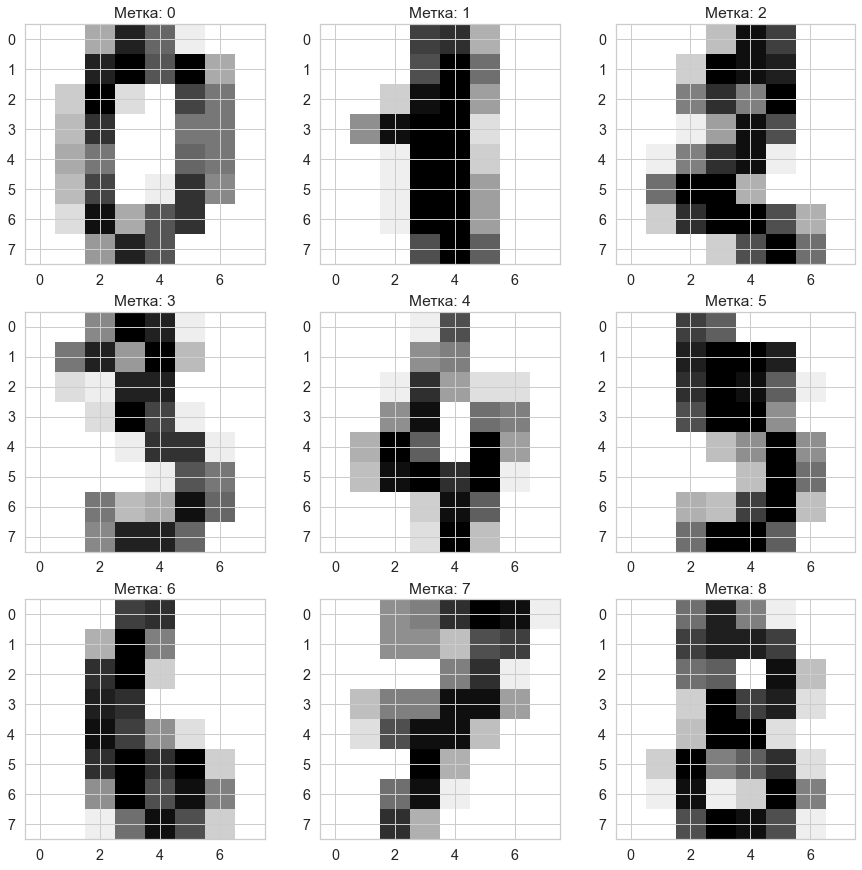

In [110]:
k = 3
_, axes = plt.subplots(k, k, figsize=(k * 5, k * 5))

for i in range(k):
    for j in range(k):
        ax = axes[i][j]
        idx = i * k + j
        plot_digit(digits['data'][idx].reshape(8, 8), ax)
        ax.set_title(f'Метка: {digits.target[idx]}')

plt.show()

In [111]:
from sklearn.preprocessing import normalize

X = normalize(digits.data)
y = digits.target

# Convert the nominal y values to binary
# TODO: y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

Реализованный в sklearn svm:

In [112]:
from sklearn import svm

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

In [113]:
y_test_predicted = clf.predict(X_test)

In [114]:
from sklearn.metrics import mean_absolute_error, accuracy_score
print('accuracy score:', accuracy_score(y_test, y_test_predicted))

accuracy score: 0.9874826147426982


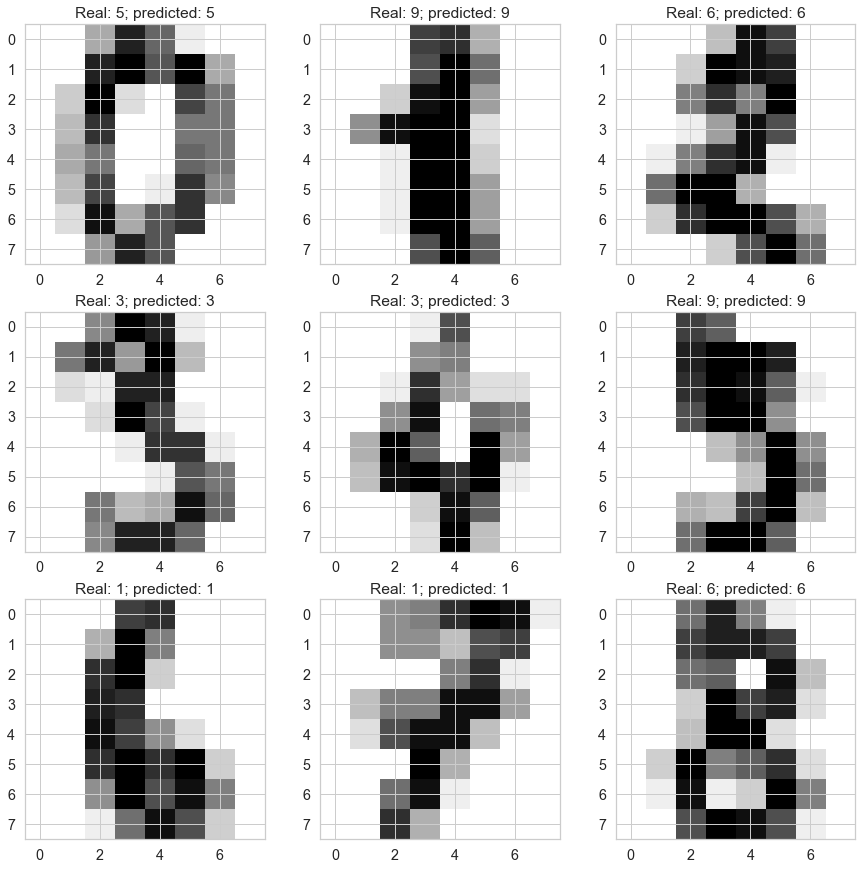

In [115]:
k = 3
_, axes = plt.subplots(k, k, figsize=(k * 5, k * 5))

for i in range(k):
    for j in range(k):
        ax = axes[i][j]
        idx = i * k + j
        plot_digit(digits['data'][idx].reshape(8, 8), ax)
        ax.set_title(f'Real: {y_test[idx]}; predicted: {y_test_predicted[idx]}')

plt.show()

Теперь хотим ввести какую-то функцию близости и обучить коэффициенты для этой функции, чтобы максимизировать точность на тренировочной выборке

### Метод опорных векторов

Какие самые универсальные и лучшие методы есть в классификации?
- метод опорных векторов
- нейронные сети
- бустинг 
(К. В. Воронцов, Школа анализа данных, Яндекс, 2020г.)

Дано:
Обучающая выборка $X^l = (x_i, y_i)_{i=1}^{l}$

$x_i$ - объекты, векторы из множества $X = R^n$

$y_i$ - метки классов, элементы множества $Y = \{-1, +1\}$

$sign(<x, w> - w_0)$

Критерий - минимизация эмпирического риска: $\sum_{i=1}^{l}[M_i(w, w_0) < 0] \rightarrow min_{w, w_0}$, где $M_i(w, w_0) = (<x_i, w>-w_0)y_i$ - отступ (margin) объекта $x_i$

Аппроксимация + регуляризация - один из способов прийти к SVM

**Оптимальная разделяющая гиперплоскость**

Пусть выборка линейно разделима. 

$\exists w, w_0$ такие, что $M_i(w, w_0) = y_i(<w_, x_i> - w_0) > 0$, $i = 1, ..., l$

Нормировка: $min_{i = 1,...l} M_i(w, w_0) = 1$

Разделяющая плоскость $\{x: -1 \leq <w, x> - w_0 \leq 1\}$

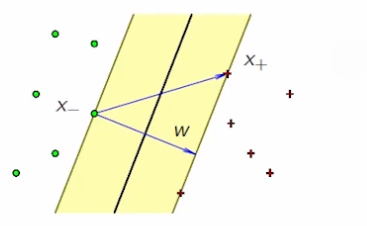

Хотим максимизировать ширину полосы. Своими краями полоса упрется в объекты обучающей выборки.

Ширина полосы: $\dfrac{<x_+ - x_i, w>}{||w||} = \dfrac{2}{||w||} \rightarrow max$

(Найдутся точки на границе полосы с $<w, x_{\pm}> - w_0 = \pm 1$ - понимаем, откуда взялся регуляризатор.

Итак, для случая линейно разделимой выборки:
    
$
\begin{cases}
  \frac{1}{2}||w||^2\rightarrow min_{w, w_0}\\
  M_i(w, w_0) \geq 1, i=1,...,l
\end{cases}\,
$

Общий случай (система неравенств несовместна):

$
\begin{cases}
  \frac{1}{2}||w||^2 + С\sum_{i=1}^l \xi_i \rightarrow min_{w, w_0, \xi_i}\\
  M_i(w, w_0) \geq 1 - \xi_i, i=1,...,l \\
  \xi_i \geq 0
\end{cases}\,
$

$\xi_i$ соответствуют штрафу за неправильное определение класса

Путем некоторых хитрых преобразований получаем эквивалентную задачу безусловной минимизации:

$C \sum_{i=1}^l(1-M_i(w, w_0))_+ + \frac{1}{2}||w||^2 \rightarrow min_{w, w_0}$

То есть, SVM - аппроксимация и регуляризация эмпирического риска.

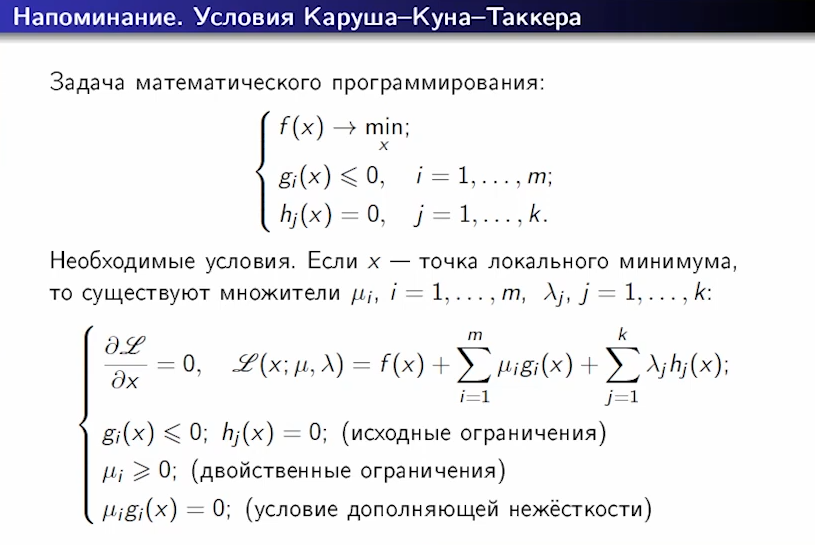

Функция Лагранжа: $L(w, w_0, \xi, \lambda, \eta) = \frac{1}{2}||w||^2 - \sum_{i=1}^{l}\lambda_i(M_i(w,w_0)-1) - \sum_{i=1}^{l}\xi_i(\lambda_i + \eta_i - C)$

Необходимые условия седловой точки функции Лагранжа

$\dfrac{\partial L}{\partial w} = w - \sum_{i=1}^l \lambda_i y_i x_i = 0 \Rightarrow w = \sum_{i=1}^l \lambda_i y_i x_i$ - линейная комбинация объектов обучающей выборки

$\lambda_i = 0$ означает, что решение задачи от этого элемента выборки не зависит. Остальные векторы называются опорными.

$\dfrac{\partial L}{\partial w_0} = -\sum_{i=1}^{l} \lambda_i y_i = 0 \Rightarrow \sum_{i=1}^{l} \lambda_i y_i = 0$

$\dfrac{\partial L}{\partial \xi_i} = -\lambda_i - \eta_i + C = 0 \Rightarrow \eta_i + \lambda_i = C, i = 1,...,l$ 

Объекты делятся на 3 типа:
- $\lambda_i = 0, \eta_i = C, \xi_i = 0, M_i > 1$ - периферийные (неинформативные объекты, глубоко в толще своего класса)
- $0 < \lambda_i < C, 0 \eta_i < C, \xi_i = 0, M_i = 1$ - опорные граничные объекты
- $\lambda_i = C, \eta_i = 0, \xi_i = 0, M_i < 1$ - опорные - нарушители (от 0 до 1 нет ошибки, но мы уже штрафуем)

**Определение** Объект $x_i$ называется опорным, если $\lambda_i \ne 0$

Таким образом, опорные объекты - не только те, которые определяют полосу, но и те, которые "выскочили" в другой класс.

Решение прямой задачи выражается через решение двойственной, если нам известны $\lambda_i$, то
    
$
\begin{cases}
  w = \sum_{i=1}^{l}\lambda_i y_i x_i\\
  w_0 = <w, x_i> - y_i, \forall i: \lambda_i > 0, M_i = 1
\end{cases}\,
$

(достаточно любой такой $x_i$ взять)

Линейный классификатор с признаками $f_i(x) = <x, x_i>$:

$a(x) = sign(\sum_{i=1}^{l}\lambda_i y_i <x, x_i> - w_0)$

Заметим, что скалярные произведения $<x, x_i>$ нам нужно знать лишь для опорных объектов. Фактически, скалярное произведение является некоторой функцией близости пары элементов.

Таким образом, метод опорных векторов в некотором смысле представляет собой выделение опорных векторов, а затем применение метрического классификатора. Можно ли скалярное произведение заменить какой-то более общей функцией близости?

### SVM с ядрами

Идея: заменить $<x, x'>$ нелинейной функцией $K(x, x')$

Переход к спрямляющему пространству, как правило, более высокой размерности $\psi: X\rightarrow H$

**Определение** функция $K: X \times X \rightarrow R$ - ядро, если $K(x, x') = <\psi(x), \psi(x')>$ при некотором $\psi: X \rightarrow H$, где $H$ - гильбертово пространство

**Теорема** функция $K(x, x')$ является ядром тогда и только тогда, когда она симметрична и неотрицательно определена:

$
\begin{cases}
  K(x, x') = K(x', x)\\
  \int_X \int_X K(x, x')g(x)g(x')dx dx' \geq 0, \forall g: X \rightarrow R
\end{cases}\,
$

Этой теоремой пользоваться неудобно, поэтому существуют **конструктивные методы синтеза ядер**:
- $K(x, x') = <x, x'>$ - ядро
- константа $K(x, x') = 1$ - ядро
- произведение ядер $K(x, x') = K_1(x, x')K_2(x, x')$ - ядро
- $\forall \psi: X \rightarrow R$ произведение $K(x, x') = \psi(x)\psi(x')$ - ядро
- $K(x, x') = \alpha_1 K_1(x, x') + \alpha_2 K_2(x, x')$ при $\alpha_1, \alpha_2 > 0$ - ядро
- $\forall \varphi: X \rightarrow X$ если $K_0$ ядро, то $K(x, x') = K_00(\varphi(x), \varphi(x'))$ - ядро 

Пример: спрямляющее пространство для квадратичного ядра.

$K(x, x') = <x, x'>^2$ - ядро, как произведение двух ядер

$K(u, v) = <u, v>^2 = <(u_1, u_2), (v_1, v_2)>^2 = (u_1 v_1 + u_2 v_2)^2 = <(u_1^2, u_2^2, \sqrt{2}u_1 u_2), (v_1^2, v_2^2, \sqrt{2}v_1 v_2)>$ таким образом, размерность пространства, в котором такое ядро является скалярным произведением, равна 3. $\psi(u_1, u_2) \rightarrow (u_1^2, u_2^2, \sqrt{2}u_1 u_2)$

Разделяющая поверхность в исходном пространстве в этом случае будет полиномом второй степени.

Чтобы получать произвольную полиномиальную поверхность, нужно использовать ядро $K(x, x') = (<x, x'> + 1)^d$ - полиномиальное ядро с мономами степени $\leq d$ (является ядром, так как очевидно получается методами синтеза ядер, описанных выше)

**Примеры ядер:**
- Ядро Фишера $U_x = \nabla_{\theta} log P(x|\theta), K(x, x') = U^T_{x_i}L^{-1}U_{x_j}$ (L - матрица информации Фишера)
- Ядро графа 
- Ядерный сглаживатели, в частности, гауссово ядро $K(x, x') = exp(-\dfrac{(x-x')^2}{2b^2})$
- Полиномиальное ядро $K(x, x') = (\sum_{i=1}^n x_i x'_i + c)^n$
- Радиальное ядро $K(x, x') = exp(-\dfrac{||x - x'||^2}{2\sigma^2})$

Линейный классификатор с признаками $f_i(x) = K(x, x_i)$:

$a(x) = sign(\sum_{i=1}^{l}\lambda_i y_i K(x, x_i) - w_0)$

**Преимущества и проблемы SVM**

Преимущества:
- задача выпуклого квадратичного программирования имеет единственное решение
- число "нейронов" определяется автоматически

Проблемы:
- нет общих подходов к оптимизации $K(x, x')$ под задачу
- нет "встроенного" отбора признаков
- приходится подбирать константу $C$

### SVM-регрессия

Модель регрессии $a(x) = <x, w> - w_0, w \in R^n, w_0 \in R$

Функция потерь $L(\epsilon) = (|\epsilon| - \delta)_+$

Постановка задачи:

$\sum_{i=1}^{l}(|<w, x_i> - w_0 - y_i| - \delta)_+ + \dfrac{1}{2 C}||w||^2 \rightarrow min$

Дальше можно перетйи к двойственной задаче, выделить опорные векторы и так далее...

### Выводы с лекции шада (TODO)

- SVM - лучший метод линейной классификации
- SVM изящно обобщается для линейной классификации, для линейной и нелинейной регрессии
- Аппроксимация пороговой функции потерь $L(M)$ увеличивает зазор и повышает качество 
- Регуляризация устраняет мультиколлинеарность и уменьшает переобучение
- Регуляризация эквивалентна введеню апрорного распределеня в пространстве коэффиентов
- $L_1$ и другие нестандартные регуляризаторы делают отбор признаков без явного перебора подмножеств

In [135]:
X, y = make_circles(n_samples = 1000, noise = 0.09)
X = preprocessing.scale(X)
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [136]:
X_train.shape

(670, 2)

In [137]:
def plot_data(X, y, title, figsize=(12, 8)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.title(title, fontsize=18)
    indices_true = (y == 1)
    indices_false = (y == -1)
    if X.shape[1] == 2:
        ax.scatter(X[indices_true, 0], X[indices_true, 1], c='r', label='label = $1$')
        ax.scatter(X[indices_false, 0], X[indices_false, 1], c='b', label='label = $-1$')
    elif X.shape[1] == 3:
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X[indices_true, 0], X[indices_true, 1],  X[indices_true, 2], c='r', label='label = $1$')
        ax.scatter(X[indices_false, 0], X[indices_false, 1], X[indices_false, 2], c='b', label='label = $-1$')
        ax.set_zlabel('feature 2', fontsize=14)
    else:
        raise ValueError('bad X shape in `plot_data`')
    ax.grid(b=True)
    ax.set_xlabel('feature 0', fontsize=14)
    ax.set_ylabel('feature 1', fontsize=14)
    ax.legend()
    plt.show()
    
def plot3D():
    
    pass

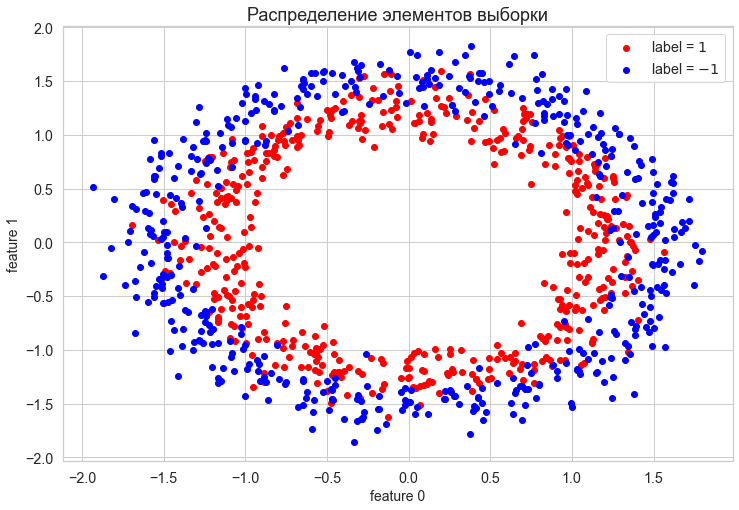

In [138]:
plot_data(X, y, 'Распределение элементов выборки')

Посмотрим, как изменится распределение выборки, если использовать упомянутое выше ядро

$K(u, v) = <u, v>^2 = <(u_1, u_2), (v_1, v_2)>^2 = (u_1 v_1 + u_2 v_2)^2 = <(u_1^2, u_2^2, \sqrt{2}u_1 u_2), (v_1^2, v_2^2, \sqrt{2}v_1 v_2)>$

$\psi(u_1, u_2) \rightarrow (u_1^2, u_2^2, \sqrt{2}u_1 u_2)$

In [139]:
warnings.filterwarnings('ignore')

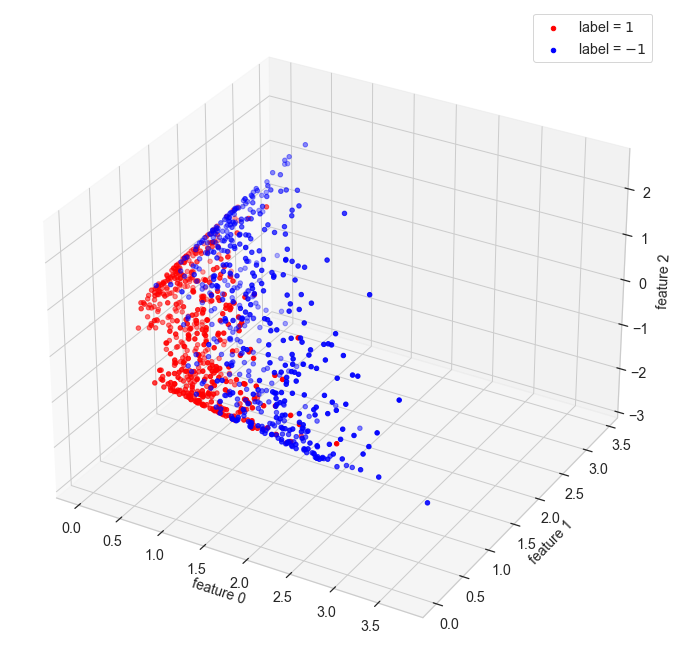

In [313]:
X_poly = np.vstack([X[:, 0]**2, X[:, 1]**2, 2**0.5 * X[:, 0] * X[:, 1]]).T
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.33)
plot_data(X_poly, y, 'Распределение элементов выборки', figsize=(12, 12))

Как видим, в этом пространстве можно гораздо лучше провести разделяющую гиперплоскость.

# TOREMOVE BEGIN

In [314]:
class support_vector_machine:
    def __init__(self, C = 10, features = 2, sigma_sq = 0.1, kernel = "None"):
        self.C = C
        self.features = features
        self.sigma_sq = sigma_sq
        self.kernel = kernel
        self.weights = np.zeros(features)
        self.bias = 0.
        
    # Определяем меру схожести эллипсов
    def __similarity(self, x, l):
        # Вычисляем экспоненциальную функцию
        return np.exp(-sum((x - l) ** 2) / (2 * self.sigma_sq))

    # Усредняем границу классов
    def gaussian_kernel(self, x1, x):
        m = x.shape[0]
        n = x1.shape[0]
        op = [[self.__similarity(x1[x_index], x[l_index]) for l_index in range(m)] for x_index in range(n)]
        return np.array(op)

    # Вычисляем потери классификации
    def loss_function(self, y, y_hat):
        sum_terms = 1 - y * y_hat
        sum_terms = np.where(sum_terms < 0, 0, sum_terms)
        return (self.C * np.sum(sum_terms) / len(y) + sum(self.weights ** 2) / 2)

    # Обучаем модель
    def fit(self, x_train, y_train, epochs = 1000, print_every_nth_epoch = 100, learning_rate = 0.01):
        y = y_train.copy()
        x = x_train.copy()
        self.initial = x.copy()
        
        assert x.shape[0] == y.shape[0] , "Samples of x and y don't match."
        assert x.shape[1] == self.features , "Number of Features don't match"
        
        if(self.kernel == "gaussian"):
            x = self.gaussian_kernel(x, x)
            m = x.shape[0]
            self.weights = np.zeros(m)

        n = x.shape[0]
        
        for epoch in range(epochs):
            # np.dot – скалярное произведение двух массивов
            y_hat = np.dot(x, self.weights) + self.bias 
            grad_weights = (-self.C * np.multiply(y, x.T).T + self.weights).T
            
            for weight in range(self.weights.shape[0]):
                grad_weights[weight] = np.where(1 - y_hat <= 0, self.weights[weight], grad_weights[weight])
            
            grad_weights = np.sum(grad_weights, axis = 1)
            self.weights -= learning_rate * grad_weights / n
            grad_bias = -y * self.bias
            grad_bias = np.where(1 - y_hat <= 0, 0, grad_bias)
            grad_bias = sum(grad_bias)
            self.bias -= grad_bias * learning_rate / n
            if((epoch + 1) % print_every_nth_epoch == 0):
                print("Эпоха {} --> Потери = {}".format(epoch + 1, self.loss_function(y, y_hat)))
    
    # Оцениваем предсказание
    def evaluate(self, x, y):
        pred = self.predict(x)
        pred = np.where(pred == -1, 0, 1)
        diff = np.abs(np.where(y == -1, 0, 1) - pred) # np.abs вычисляет абсоюлтное значение (модуль числа)
        return((len(diff) - sum(diff)) / len(diff))

    # Предсказываем класс для новых наблюдений
    def predict(self, x):
        if(self.kernel == "gaussian"):
            x = self.gaussian_kernel(x, self.initial)
        return np.where(np.dot(x, self.weights) + self.bias > 0, 1, -1)

In [319]:
def visualize(model, X_test, y_test, title):
    print("Тестовая точность = {}".format(model.evaluate(X_test, y_test)))
    # Для наглядности точки заливаются в двумерный график, где x находится в пределах от -5 до 6, а y – от -5 до 4
    x1 = np.arange(-5, 6, 0.3) # np.arange возвращает равномерно раскиданные значения с шагом 0.3 в интервале от -5 до 6
    x2 = np.arange(-5, 4, 0.3)
    
    for i in range(len(x1)):
        for j in range(len(x2)):
            # Генерируем предсказания классов точек
            pred = model.predict(np.array([np.array(np.array([x1[i], x2[j]]))]))[0]
            if(pred > 0.5):
                plt.scatter(x1[i], x2[j], c = "r")
            else:
                plt.scatter(x1[i], x2[j], c = "b")
    plt.title(title)
    plt.show()

In [317]:
model = support_vector_machine(features=3, C = 10, kernel=None, sigma_sq = 0.01)
model.fit(X_train_poly, y_train_poly, epochs = 20, print_every_nth_epoch = 2, learning_rate = 0.01)
print("Точность обучения = {}".format(model.evaluate(X_test_poly, y_test_poly)))

Эпоха 2 --> Потери = 9.91464279734365
Эпоха 4 --> Потери = 9.748119816099212
Эпоха 6 --> Потери = 9.588125043856689
Эпоха 8 --> Потери = 9.434401909005482
Эпоха 10 --> Потери = 9.286703936629324
Эпоха 12 --> Потери = 9.144794350919929
Эпоха 14 --> Потери = 9.013197289169348
Эпоха 16 --> Потери = 8.903779545611087
Эпоха 18 --> Потери = 8.838884970488635
Эпоха 20 --> Потери = 8.83578575864796
Точность обучения = 0.509090909090909


In [320]:
visualize(model, X_test, y_test, "Метод опорных векторов с гауссовым ядром")

Тестовая точность = 0.509090909090909


ValueError: shapes (1,2) and (3,) not aligned: 2 (dim 1) != 3 (dim 0)

# TOREMOVE END

In [369]:
X_poly = np.vstack([X[:, 0]**2, X[:, 1]**2, 2**0.5 * X[:, 0] * X[:, 1], X[:, 0], X[:, 1], [1] * X.shape[0]]).T
print(X_poly.shape)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.33)

(1000, 6)


In [370]:
# backtracking и GradientDescent скопированы с https://github.com/Aaaaanyaaaaaaa

def get_f_k_phi1_phi2(x, f, grad_f, X_train, y_train, C, alpha, beta1, beta2):
    f_x = f(x, X_train, y_train, C)
    if isinstance(grad_f ,types.FunctionType):
        grad_f_x = grad_f(x, X_train, y_train, C)
        phi1 = f_x -  beta1 * alpha * grad_f_x.dot(grad_f_x)
        phi2 = f_x -  beta2 * alpha * grad_f_x.dot(grad_f_x)
        f_k = f(x - alpha * grad_f_x, X_train, y_train, C)
    else:
        phi1 = f_x -  beta1 * alpha * grad_f @ grad_f
        phi2 = f_x -  beta2 * alpha * grad_f @ grad_f  
        f_k = f(x - alpha * grad_f, X_train, y_train, C)
    return f_k, phi1, phi2


def backtracking(x, f, grad_f, X_train, y_train, C, rho, alpha0, beta1, beta2):
    alpha = alpha0
    f_k, phi1, phi2 = get_f_k_phi1_phi2(x, f, grad_f, X_train, y_train, C, alpha, beta1, beta2)
    
    while not ((f_k <=phi1) and (f_k >=phi2)):
        alpha *= rho
        f_k, phi1, phi2 = get_f_k_phi1_phi2(x, f, grad_f, X_train, y_train, C, alpha, beta1, beta2)
        if alpha < 1e-17:
            return alpha / rho
    
    return alpha


def gradient_descent(f, gradf, x0, X_train, y_train, C, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = []
  
    while True:
        beta2 = 1. -beta1
        alpha = 0.1 / (iteration + 1)
        # alpha = backtracking(x, f, gradf, X_train, y_train, C, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x, X_train, y_train, C)
        x = x - alpha * gradient
        iteration += 1
        if np.linalg.norm(gradient) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
        
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradient),  "conv_array": np.array(conv_array)}
    return res

In [371]:
def f(w, X_train, y_train, C):
    assert(X_train.shape[1] == w.shape[0])
    assert(y_train.shape[0] == X_train.shape[0])
    return np.linalg.norm(w)**2 / 2 + C * (1 - min(y_train.dot(X_train @ w), 1))


def grad_f(w, X_train, y_train, C):
    assert(X_train.shape[1] == w.shape[0])
    assert(y_train.shape[0] == X_train.shape[0])
    filtered = (y_train * (X_train @ w) < 1)
    assert(filtered.shape == (X_train.shape[0],))
    answer = w - (C * X_train * y_train.reshape(-1, 1) * filtered.reshape(-1, 1)).sum(axis=0) / X_train.shape[0]
    return answer

In [372]:
C = 1000
w0 = np.zeros(X_train_poly.shape[1])
res = gradient_descent(f, grad_f, w0, X_train_poly, y_train_poly, C)

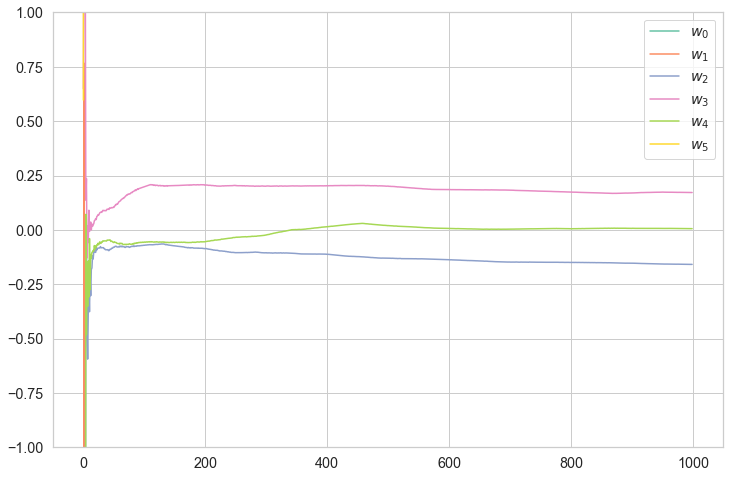

In [373]:
plt.figure(figsize=(12, 8))
conv_array = res['conv_array']
for i in range(len(conv_array[0])):
    plt.plot(np.arange(len(conv_array)), conv_array[:,i], label=f'$w_{i}$')
plt.grid(b=True)
plt.ylim(-1, 1)
plt.legend()
plt.show()

In [374]:
def predict(X_test, w):
    return np.where(X_test @ w < 0, -1, 1)

y_test_predicted = predict(X_test_poly, res['x'])

In [375]:
print(y_test_poly.shape)
print(y_test_predicted.shape)

(330,)
(330,)


In [376]:
print('accuracy score:', accuracy_score(y_test_poly, y_test_predicted))

accuracy score: 0.8090909090909091


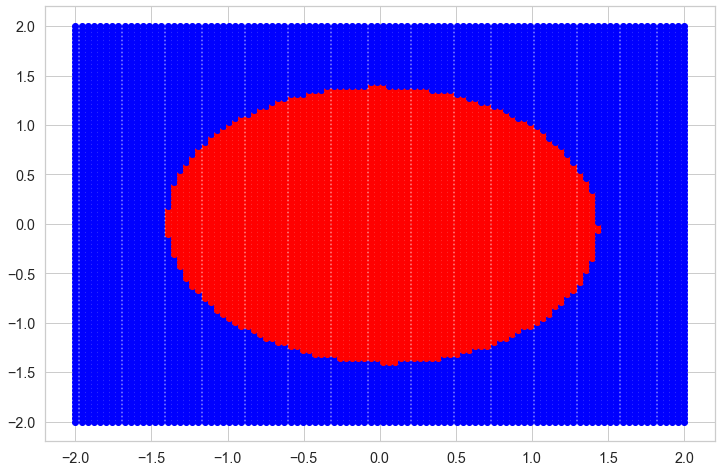

In [385]:
plt.figure(figsize=(12, 8))
x_grid = np.linspace(-2, 2, 100)
for x0 in x_grid:
    for x1 in x_grid:
        x_sample = np.array([x0**2, x1**2, 2**0.5 * x0 * x1, x0, x1, 1]).reshape(1, -1)
        y = predict(x_sample, res['x'])[0]
        color = 'r' if y == 1 else 'b'
        plt.scatter(x0, x1, c=color)
plt.show()